# MNIST-手写数字识别-CNN-Tensorflow

## 1) 数据采集

https://www.kaggle.com/c/digit-recognizer

## 2) 数据探索

### 2.1） 导入相关包

In [1]:
# 用于读取数据、处理数据
import pandas as pd
import numpy as np

# 用于可视化
import matplotlib.pyplot as plt

# 用于数据预处理
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

# 建立CNN模型
import tensorflow as tf

c:\users\33181\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\33181\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\33181\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\33181\appd

### 2.2) 读取数据

In [2]:
train = pd.read_csv('C:/Users/Public/OneDrive/train.csv')
test = pd.read_csv('C:/Users/Public/OneDrive/test.csv')

In [3]:
# 数据示例
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.3) 数据解析

从2.2可以看出，数据主要分为**label**和**pixel**，每一个样本为28$\times$28的图片，共有784个特征值($pixel0 - pixel783$)
- **label:** 每一行数据对应的标签。
- **pixel:** 对应每个像素点的灰度值，其范围在0-255之间

### 2.4) 数据维度

In [4]:
print('train shape:{}'.format(train.shape))
print('test shape:{}'.format(test.shape))

train shape:(42000, 785)
test shape:(28000, 784)


训练集共有42000个样本，测试集有28000

In [5]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


### 2.5) 是否缺失值

In [6]:
train.isnull().any().sum()

0

In [7]:
test.isnull().any().sum()

0

无论训练集或者测试中都没有缺失值

## 3) 可视化

### 3.1) 看看数据长什么样

上面提到每个样本是一个28$\times$28的图片，那么现在随机挑选几个样本，看看它都长什么样

In [8]:
random_index = np.random.randint(0, 42000, size=40)
print(random_index)

[ 7667 23884 16064  3443 31132 19106  1189 25125 40891 26377 40359 18897
 16406  4275  8351 26556 27706 12547   128 11842 20641 41568 29106 25059
 13734 31519 39832 40265 12690 18309 24617  5671 29259  4916 30689 31763
  9565  2683 40315  1492]


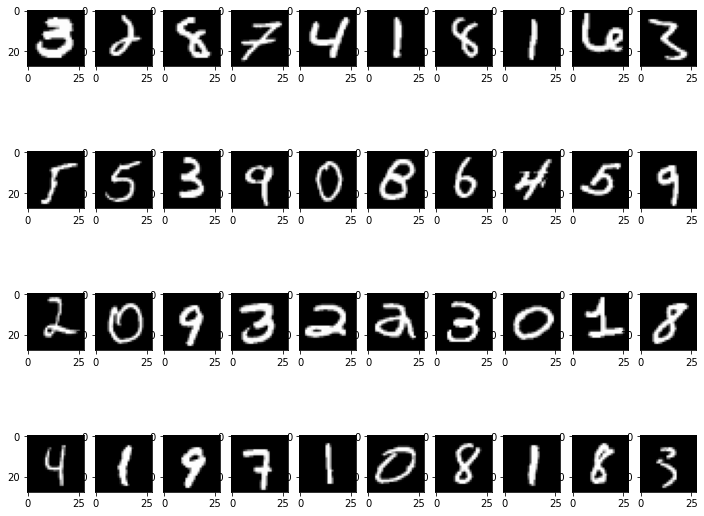

In [9]:
plt.figure(figsize=(12,10))
for i, index in enumerate(random_index):
    plt.subplot(4, 10, i+1)
    plt.imshow(train.iloc[index, 1:].values.reshape(28, 28),cmap='gray')
plt.show()

### 3.2) 标签的分布

检查是否存在数据不均衡问题

In [10]:
t = train['label'].value_counts()

Text(0.5, 1.0, "Distribution of Label's")

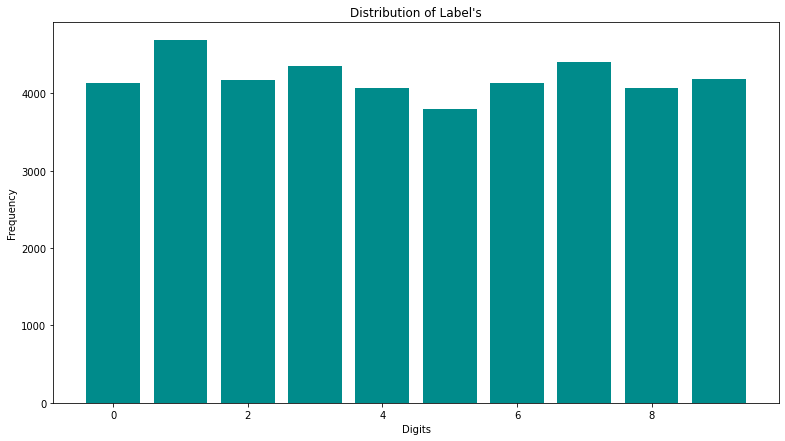

In [11]:
plt.figure(figsize=(13,7))
plt.bar(t.index, t.values, color='#008B8B')
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.title('Distribution of Label\'s')

<br\>可以看出0-9分布基本均匀，无需针对不均衡问题做处理。

## 4) 数据预处理

### 4.1) 设置随机数种子

为了结果可重现，设置随机数种子，这样每次相同代码执行的随机结果都是一致的

In [12]:
seed = 16
np.random.seed(seed)

### 4.2) 训练集验证集划分

将样本划分为训练集和验证集，以验证集来评估模型的性能

In [13]:
X = train.iloc[:,1:]
Y = train.iloc[:,0]
X_train , X_test , y_train , y_test = train_test_split(X, Y , test_size=0.1, random_state=seed)

### 4.3) 重塑样本

目前我们拥有的都是由784个像素值组成的$1D$样本。为了使用CNN模型，我们需要将其重塑成$28\times28$的矩阵。第一维表示样本数量，第二、三维表示图片的长宽，而最后一维表示图片的颜色通道数量，本案例中样本为灰度图，所以通道数为1，若rgb彩色图，则为3。

In [14]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

### 4.4) 规范化

对特征规范化通常是为了去量纲，使得各特征都在同一尺度中，这样在梯度下降或者其他优化算法中不会出现在某一方向梯度过大而其他方向梯度过小的情况。
1. 规范化将所有值都缩放到(0, 1)之间。
2. 使得在梯度下降时收敛的更快。
3. 使得所有特征都在同一尺度上，且同时均衡所有特征的权重。
4. 同时在一定程度上去除噪音。比如当照片被提高或者降低亮度时，规范化可以去除这种影响。
<br\><br\> 规范化由$x=\frac{x-min(x)}{max(x)-min(x)}$来执行。在本案例中，$min(x)=0,max(x)=255$

In [15]:
X_train = X_train/255
X_test = X_test/255

### 4.5) 标签One-Hot编码

目前目标值标签还是0-9的数字，需要将其编码为One-hot向量，比如$0\rightarrow[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],1\rightarrow[0, 1 ,0, 0, 0, 0, 0, 0, 0, 0]$等

In [16]:
env = preprocessing.OneHotEncoder(sparse=False)
y_train = env.fit_transform(y_train.values.reshape(-1, 1))
y_test = env.transform(y_test.values.reshape(-1, 1))

实际上这里的OneHot，由于目标值是0、1...9数字，相当于已经标签化，因此可以使用numpy一行代码也可以实现。
    <br\> `y_train = np.eye(C)[y_train.values.reshape(-1)]`

## 5) 训练卷积神经网络

### 5.1) 为什么选择CNN

--待补充说明

### 5.2) 使用Tensorflow构建CNN

--待补充说明

这里将构建三层的卷积神经网络。其结构为:<br>[卷积层->relu->卷积层->relu->max池化->dropout]->[卷积层->relu->卷积层->relu->max池化->dropout]->[全连接层->dropout->输出层]

In [17]:
# 创建输入数据的placeholder
x_input = tf.placeholder('float', shape=[None, 28, 28, 1])
y_input = tf.placeholder('float', shape=[None, 10])

In [18]:
# 第一层 卷积层->relu->卷积层->relu->max池化->dropout
W_conv1_1 = tf.get_variable('W_conv1_1', [5, 5, 1, 32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
b_conv1_1 = tf.get_variable('b_conv1_1', [32], initializer=tf.zeros_initializer())
W_conv1_2 = tf.get_variable('W_conv1_2', [5, 5, 32, 32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
b_conv1_2 = tf.get_variable('b_conv1_2', [32], initializer=tf.zeros_initializer())
keep_prob1 = tf.placeholder('float', name='keep_prob1')   # 为了测试时不使用dropout，为keep_prob 创建一个placeholder,这样在测试时可以将其设置为1

h_conv1_1 = tf.add(tf.nn.conv2d(x_input, W_conv1_1, strides=[1, 1, 1, 1], padding='SAME'), b_conv1_1, name='h_conv1_1')
h_relu1_1 = tf.nn.relu(h_conv1_1, name='h_relu1_1')

h_conv1_2 = tf.add(tf.nn.conv2d(h_relu1_1, W_conv1_2, strides=[1, 1, 1, 1], padding='SAME'), b_conv1_2, name='h_conv1_2')
h_relu1_2 = tf.nn.relu(h_conv1_2, name='h_relu1_2')

h_pool1 = tf.nn.max_pool(h_relu1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='h_pool1')

h_drop1 = tf.nn.dropout(h_pool1, keep_prob=keep_prob1, name='h_drop1')


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
# 第二层 卷积层-> 卷积层->relu->卷积层->relu->max池化->dropout
W_conv2_1 = tf.get_variable('W_conv2_1', [5, 5, 32, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))
b_conv2_1 = tf.get_variable('b_conv2_1', [64], initializer=tf.zeros_initializer())
W_conv2_2 = tf.get_variable('W_conv2_2', [5, 5, 64, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))
b_conv2_2 = tf.get_variable('b_conv2_2', [64], initializer=tf.zeros_initializer())
keep_prob2 = tf.placeholder('float', name='keep_prob2')  # 为了测试时不使用dropout，为keep_prob 创建一个placeholder,这样在测试时可以将其设置为1

h_conv2_1 = tf.add(tf.nn.conv2d(h_drop1, W_conv2_1, strides=[1, 1, 1, 1], padding='SAME'), b_conv2_1, name='h_conv2_1')
h_relu2_1 = tf.nn.relu(h_conv2_1, name='h_relu2_1')

h_conv2_2 = tf.add(tf.nn.conv2d(h_relu2_1, W_conv2_2, strides=[1, 1, 1, 1], padding='SAME'), b_conv2_2,
                   name='h_conv1_2')
h_relu2_2 = tf.nn.relu(h_conv2_2, name='h_relu1_2')

h_pool2 = tf.nn.max_pool(h_relu2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='h_pool2')

h_drop2 = tf.nn.dropout(h_pool2, keep_prob=keep_prob2, name='h_drop2')

In [20]:
# 第三层 全连接层->dropout->输出层
W_fc1 = tf.get_variable('W_fc1', [7 * 7 * 64, 256], initializer=tf.contrib.layers.xavier_initializer(seed=0))
b_fc1 = tf.get_variable('b_fc1', [256], initializer=tf.zeros_initializer())
W_output = tf.get_variable('W_fc2', [256, 10], initializer=tf.contrib.layers.xavier_initializer(seed=0))
b_output = tf.get_variable('b_fc2', [10], initializer=tf.zeros_initializer())
keep_prob3 = tf.placeholder('float', name='keep_prob3')

h_flat = tf.reshape(h_drop2, [-1, 7 * 7 * 64])
h_fc1 = tf.matmul(h_flat, W_fc1) + b_fc1
h_fc_drop = tf.nn.dropout(h_fc1, keep_prob=keep_prob3, name='h_fc_drop')
y_output = tf.matmul(h_fc_drop, W_output) + b_output

In [21]:
sess = tf.Session()

### 5.3) 分割数据为batch

定义一个函数，输入为样本与对应标签，返回batch list集合，用于批量梯度下降。

In [22]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[0]  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(
        m / mini_batch_size)  # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size: k * mini_batch_size + mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size: k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size: m, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size: m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

### 5.4）数据增强
为了减少过拟合，需要人工增加图片数据。其核心思想是通过对原图片上施加微小的变换，来模拟生成同样标签的数据，如略微放大一张`9`的手写字，放大之后依然是`9`；略微倾斜后也依然是`9`。

创建一个`placeholder`作为数据增强的输入

In [23]:
sess = tf.Session()
data_to_augment = tf.placeholder(tf.float32, [None, 28, 28, 1])
m = tf.shape(data_to_augment)[0]

#### 1.随机剪裁
- 使用`tf.random_crop`随机剪取原图片中一部分
- 使用`tf.image.resize_images`将图片重塑至原来的大小
<br><br> 相当于随机取其中一块图片，然后放大至原来的大小

In [24]:
original_size = [28, 28]
# Use the following commands to perform random crops
crop_size = [m, 25, 25, 1]
seed = 10
crop_x = tf.random_crop(data_to_augment, size = crop_size, seed = seed)
X_random_crop = tf.image.resize_images(crop_x, [28, 28])

###### 看看剪裁前后的差异
- 剪裁前：

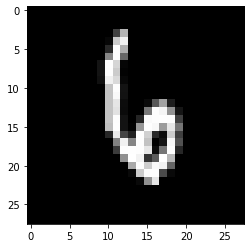

In [25]:
plt.imshow(X_train[1000, :, :, 0], cmap='gray')

- 剪裁后：

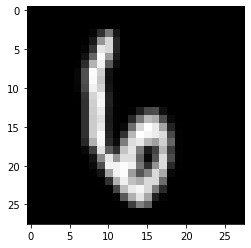

In [26]:
plt.imshow(sess.run(X_random_crop, feed_dict={data_to_augment:X_train[[1000], :, : ,: ]})[0, :,:,0], cmap='gray')

#### 2.水平、垂直移动
移位只涉及沿X或Y方向（或两者）移动图像。
- 使用`tf.image.pad_to_bounding_box`向图片四周填充3个为0的像素点
- 使用`tf.tf.image.crop_to_bounding_box`截取图片中的指定位置，实现图片的水平、垂直移动
<br><br>通过这步骤二可以实现水平移动或垂直移动或者斜角移动
<br> 事实上使用numpy 也同样可以较为简单的实现移动图片，为了和其他图片增强方法一致，这里统一使用tensorflow的现有api

In [27]:
pad_x = tf.image.pad_to_bounding_box(data_to_augment, 3, 3, 34, 34) #原size 为（28， 28），在填充后为(34, 34)

In [28]:
up_shift_x = tf.image.crop_to_bounding_box(pad_x, 6, 3, 28, 28) # 等价于向上移动三个像素
down_shift_x = tf.image.crop_to_bounding_box(pad_x, 0, 3, 28, 28) # 等价于向下移动三个像素
left_shift_x = tf.image.crop_to_bounding_box(pad_x, 3, 6, 28, 28) # 等价于向左移动三个像素
right_shift_x = tf.image.crop_to_bounding_box(pad_x, 3, 0, 28, 28) # 等价于向右移动三个像素

right_down_x = tf.image.crop_to_bounding_box(pad_x, 0, 0, 28, 28)
left_up_x = tf.image.crop_to_bounding_box(pad_x, 6, 6, 28, 28)
right_up_x = tf.image.crop_to_bounding_box(pad_x, 0, 6, 28, 28)
left_down_x = tf.image.crop_to_bounding_box(pad_x, 6, 0, 28, 28)

###### 看看移动后的效果
- 移动前：

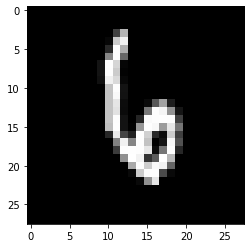

In [29]:
plt.imshow(X_train[1000, :, :, 0], cmap='gray')

- 向左移动后：

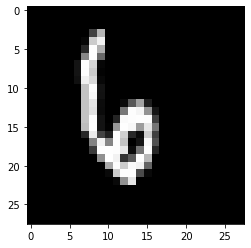

In [30]:
plt.imshow(sess.run(tf.reshape(left_shift_x, [28, 28]), feed_dict={data_to_augment:X_train[[1000], :, :, :]}), cmap='gray')

- 向上移动后：

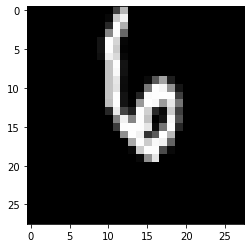

In [31]:
plt.imshow(sess.run(tf.reshape(up_shift_x, [28, 28]), feed_dict={data_to_augment:X_train[[1000], :, :, :]}), cmap='gray')

#### 3. 旋转
- 使用`tf.contrib.image.rotate`将图片旋转至指定角度。
<br>图片旋转有一个关键问题：旋转之后图像的维数可能并不能保持跟原来一至。`tf.contrib.image.rotate`中可以使用最临近插值补齐缺失的维度

In [32]:
forward_rotate_x_10 = tf.contrib.image.rotate(data_to_augment,10 * np.pi / 180) # 向前旋转10度（逆时针）
forward_rotate_x_5 = tf.contrib.image.rotate(data_to_augment,5 * np.pi / 180)
backward_rotate_x_10 = tf.contrib.image.rotate(data_to_augment,-10 * np.pi / 180) #向后旋转10度(顺时针)
backward_rotate_x_5 = tf.contrib.image.rotate(data_to_augment,-5 * np.pi / 180)
forward_rotate_x_7 = tf.contrib.image.rotate(data_to_augment,7 * np.pi / 180) 
forward_rotate_x_12 = tf.contrib.image.rotate(data_to_augment,12 * np.pi / 180)
backward_rotate_x_7 = tf.contrib.image.rotate(data_to_augment,-7 * np.pi / 180) 
backward_rotate_x_12 = tf.contrib.image.rotate(data_to_augment,-12 * np.pi / 180)
backward_rotate_x_15 = tf.contrib.image.rotate(data_to_augment,-15 * np.pi / 180)
forward_rotate_x_15 = tf.contrib.image.rotate(data_to_augment,15 * np.pi / 180)

###### 看看旋转后的效果
- 旋转前：

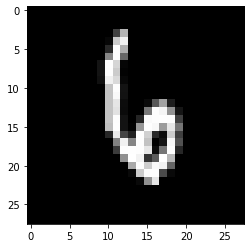

In [33]:
plt.imshow(X_train[1000, :, :, 0], cmap='gray')

- 向前旋转十度后：

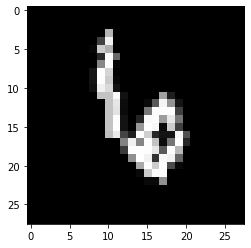

In [34]:
plt.imshow(sess.run(tf.reshape(forward_rotate_x_10, [28, 28]), feed_dict={data_to_augment:X_train[[1000], :, :, :]}), cmap='gray')

- 向后旋转十度后：

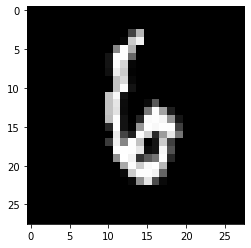

In [35]:
plt.imshow(sess.run(tf.reshape(backward_rotate_x_10, [28, 28]), feed_dict={data_to_augment:X_train[[1000], :, :, :]}), cmap='gray')

In [36]:
augment_set = tf.concat([X_random_crop, X_random_crop,up_shift_x, down_shift_x, 
                         right_shift_x, left_shift_x, right_down_x, left_up_x, right_up_x, left_down_x,
                         forward_rotate_x_10, forward_rotate_x_5, 
                         backward_rotate_x_10, backward_rotate_x_5,forward_rotate_x_7, forward_rotate_x_12, 
                         backward_rotate_x_7, backward_rotate_x_12, backward_rotate_x_15,
                         forward_rotate_x_15, data_to_augment], 0) # 将所有的数据合并，包括原数据

In [37]:
X_train_augment = sess.run(augment_set, feed_dict={data_to_augment:X_train})
y_train_augment = np.tile(y_train, [21, 1])

In [38]:
X_train_augment.shape # 数据增强后将数据量增加至原来的21倍

(793800, 28, 28, 1)

In [39]:
y_train_augment.shape

(793800, 10)

### 5.5）训练模型并输出日志

In [40]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_output, labels=y_input))

correct_prediction = tf.equal(tf.argmax(y_output, 1), tf.argmax(y_input, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

# 训练步骤，这里训练集使用adam算法做梯度下降
train_step = tf.train.AdamOptimizer(0.0001).minimize(cost)

# 创建回话
# sess = tf.Session()

# 初始化所有变量
init = tf.global_variables_initializer()
sess.run(init)

num_batches = int(X_train_augment.shape[0] / 64)
seed = 0

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.





In [41]:
train_costs = []
test_costs = []
train_accuracys = []
test_accuracys = []
for i in range(10):
    seed += 1
    minbatchs = random_mini_batches(X_train_augment, y_train_augment, 64, seed)

    epoch_cost = 0
    epoch_accuracy = 0
    for minibath in minbatchs:
        minibatch_X, minibatch_Y = minibath

        feed_dict = {x_input: minibatch_X, y_input: minibatch_Y,  keep_prob1: 0.25, keep_prob2: 0.25, keep_prob3: 0.35}
        _ = sess.run(train_step, feed_dict=feed_dict)

        minibatchs_cost, minibatchs_accuracy = sess.run([cost, accuracy],
                                   feed_dict={x_input: minibatch_X, y_input: minibatch_Y,  keep_prob1: 1,
                                              keep_prob2: 1, keep_prob3:1})
        epoch_cost += minibatchs_cost / num_batches
        epoch_accuracy +=  minibatchs_accuracy / num_batches
    
    test_cost, test_accuracy = sess.run([cost, accuracy],
                                        feed_dict={x_input: X_test, y_input: y_test,
                                                   keep_prob2: 1, keep_prob1: 1, keep_prob3:1})
    
    train_costs.append(epoch_cost)
    test_costs.append(test_cost)
    train_accuracys.append(epoch_accuracy)
    test_accuracys.append(test_accuracy)
    if i % 1 == 0:
        print('{}th iter, train cost is {:.5f},train accuracy is {:.5f} ,test cost is {:.5f}, test accuracy is {:.5f}'.format(
            i, epoch_cost, epoch_accuracy,test_cost, test_accuracy))

KeyboardInterrupt: 

## 6) 评估模型

### 6.1) 训练曲线和验证曲线

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(np.arange(10), train_costs, label="Training loss")
plt.plot(np.arange(10), test_costs, label="Test loss")
_ = plt.legend()
plt.subplot(2, 1, 2)
plt.plot(np.arange(10), train_accuracys, label="Training accuracy")
plt.plot(np.arange(10), test_accuracys, label="Test accuracy")
_ = plt.legend()

可以看出来，事实上还是有过拟合的情况存在的。在迭代五次之后，验证集的准确率就稳定在0.994左右，当然如果没有使用数据增强，验证集将稳定在0.991左右。再最后将全部数据加入训练时，设置迭代30次后，将会达到0.997的准确率。

### 6.2) 混淆矩阵

In [ ]:
predict = tf.argmax(y_output, 1)
Y_pred_classes = sess.run(predict, feed_dict={x_input: X_test, keep_prob1: 1,keep_prob2: 1, keep_prob3:1})

In [ ]:
confusion_mtx = confusion_matrix(np.argmax(y_test, 1), Y_pred_classes) 
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10), range(10))
plt.yticks(range(10), range(10))
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
thresh = confusion_mtx.max() / 2
for i in range(10):
    for j in range(10):
        plt.text(j, i, confusion_mtx[i, j],
                 horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")

看起来分类错误最多就是把`4`误分类为`9`，以及把`5`误分类为`3`，看看这些被误分类的图片。

In [ ]:
Y_true = np.argmax(y_test, 1)
errors = (Y_pred_classes != Y_true)
Y_true_erros = Y_true[errors]
Y_pred_erros = Y_pred_classes[errors]
X_test_erros = X_test[errors]

In [ ]:
random_index = np.arange(12)
plt.figure(figsize=(13,11))
for i, index in enumerate(random_index):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test_erros[index, :, :, 0],cmap='gray')
    plt.title('the true label is {}\n predict label is {}'.format(Y_true_erros[index], Y_pred_erros[index]))

可以看出来，有些图片确实难以辨认，即便由人类来辨认，也难保不会出错。当然模型还可以进一步改善，目前也还算不是太差的模型。

## 7) 将验证集也加入训练，重新训练模型，提交结果

在以上代码中，将训练集按1:9分为验证集和训练集，提交结果之前，将训练集全部加入训练集，重新训练模型。最终提交到kaggle的结果为0.99700，top7%。

In [ ]:
results = sess.run(predict, feed_dict={x_input: test.values.reshape(-1, 28, 28, 1) / 255, keep_prob1: 1,keep_prob2: 1, keep_prob3:1})
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("cnn_mnist_datagen6.csv",index=False)

Task was destroyed but it is pending!
task: <Task pending coro=<Kernel.poll_control_queue() running at c:\users\33181\appdata\local\programs\python\python37\lib\site-packages\ipykernel\kernelbase.py:241> wait_for=<Future finished result=<Future at 0x...state=pending>> cb=[_chain_future.<locals>._call_set_state() at c:\users\33181\appdata\local\programs\python\python37\lib\asyncio\futures.py:358]>
